
#  Mass-Constrained Neural Networks Model for Aqueous Chemical Speciation 

#### Ricardo Lara
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences


____________________
Contributions:
#### Honggeun Jo kindly helped me implement mass balance constraint in the output layer of the NN model.

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)

---
### Executive Summary
Neural networks can be used as surrogates for nonlinear physical models to significantly increase computational speed. However, standard neural network models do not enforce fundamental physical constraints like mass conservation. In this workflow, we investigated the direct inclusion of mass conservation constraint into the architecture of the neural network to predict the aqueous speciation of $NaCl$, $CaCl_2$, $MgCl_2$, and $Na_2SO_4$ salts in pure water. The results show that, in comparison with the standard neural networks, mass-constrained neural networks significantly reduced de mass balance residual. It is recommended to further investigate hyperparameter tuning of mass-constrained neural network models.



---
### Background
#### Aqueous Speciation
Equilibrium speciation calculations consist in solving a non-linear system of mass action equations along with the mass conservation law to obtain the distribution of chemical species (ions and complexes) for a given chemical composition. Chemical equilibrium calculations are part of reactive transport models that spawn a wide range of applications including the oil industry. One particular example is low-salinity waterflooding, where the transport and adsorption of ions are believed to change the wettability of rock surface.

The challenge of running simulations of chemical equilibrium calculations is that it is computationally expensive. It involves the iterative solution of nonlinear algebraic equations along with the calculation of factors, such as activities and fugacities, to correct for non-idealities. Therefore, performing tasks like uncertaintiy quantification becomes unfeasible. 

In this workflow, we consider the problem for the aqueous speciation of $NaCl$, $CaCl_2$, $MgCl_2$, and $Na_2SO_4$ salts in pure water. These salts disassociate in solution and form ions and complexes, as shown in the figure below. The solution consists in calculating the concentration of each ion and complex in solution (e.g., $Na^+$, $Ca^{+2}$, $MgSO_4$, ...) as function of the total concentration of each chemical component ($Na$, $Ca$, $Mg$, $Cl$, $S$).

<p align="center">
    <img src="https://github.com/rlarao/aq_speciation/blob/main/salts.png?raw=true" width="440" height="480" />

</p>



#### Mass-Constrained Artificial Neural Networks
Artificial neural networks (ANN) as a surrogate model for chemical equilibrium calculations because they are computationally cheaper models that, along with non-linear activation functions, are regarded as universal function approximators. However, it has been point out in the literature that ANN do not conserve mass. The errors in the chemical speciation can be accepted given the uncertainty of the equilibrium constants, however, mass conservation is a physical contraint that should always be honored.

In this workflow, we investigate the mass-constrained ANN by adding a node that calculates the mass balance residuals as a function of the components concentration given in the inputs and the aqueous species given in the first output layer. The first output layer and the constraint layer are concatenated to form the output of the model in which the mean square error MSE will be calculated.


<p align="center">
    <img src="https://github.com/rlarao/aq_speciation/blob/main/nn.png?raw=true" width="480" height="720" />

</p>


***
### Import Packages

In [1]:
# standard packages for visualization and matrix operations
import re
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# train / test split             
from sklearn.model_selection import train_test_split              

# Packages for artificial neural networks
import tensorflow as tf  
from tensorflow import keras   

***
### Functions
The following functions will be used in the workflow to break down the chemical formulas into its chemical elements.

In [2]:
ELEMENT_CLAUSE = re.compile("([A-Z][a-z]?)([0-9]*)")
def parse_compound(compound):
    """
    Given a chemical compound like Na2SO4,
    return a dict of element counts like {"Na":2, "S":1, "O":4}
    """
    return {el: (int(num) if num else 1) for el, num in ELEMENT_CLAUSE.findall(compound)}

***
### Load data
The following workflow uses the .csv file 'dataset_15000.csv', a synthetic dataset that was generated using the open-source, geochemical solver PHREEQC v3.6.2 developed by the United States Geological Survey. The dataset contains the aqueous speciation solution for the addition of $NaCl$, $CaCl_2$, $MgCl_2$, and $Na_2SO_4$ salts to pure water with a given pH.


The predictor features are the initial solution $pH$ and the chemical concentration of components added in mol/L: $Na$, $Cl$, $Ca$, $Mg$, $S$. 

The response features are the speciation the final solution $pH$ and the molarity of the free ions and complexes in solution:
$Na^+$, $Cl^-$, $Ca^{+2}$, $Mg^{+2}$, $SO_4^{-2}$, $CaSO_4$, $CaOH^+$, $CaHSO_4^+$, $NaSO_4^-$, $NaOH$, $MgOH^+$, $HSO_4^-$, $MgSO_4$

In [3]:
os.chdir('c:/PGE383')
my_data = pd.read_csv('dataset_15000.csv', delimiter= ',')

***
### Basic Data Checking, and Visualization


In [4]:
my_data.describe().transpose()

count          mean           std           min           25%  \
Na         15000.0  4.126798e-01  2.538006e-01  2.665100e-03  2.080075e-01   
Cl         15000.0  6.832687e-01  3.621430e-01  2.883500e-02  3.846525e-01   
Ca         15000.0  1.361545e-01  1.059280e-01  1.080000e-05  5.175250e-02   
Mg         15000.0  1.365864e-01  1.061827e-01  2.420000e-05  5.287750e-02   
S(6)       15000.0  1.374465e-01  1.069447e-01  5.490000e-05  5.319300e-02   
pH         15000.0 -7.514990e+00  1.436790e+00 -9.999960e+00 -8.740255e+00   
m_Ca+2     15000.0  1.108001e-01  9.219411e-02  9.440000e-06  4.040475e-02   
m_CaSO4    15000.0  2.535379e-02  2.431741e-02  4.170000e-07  7.180700e-03   
m_CaOH+    15000.0  4.172503e-07  1.447093e-06  6.030000e-12  7.500000e-09   
m_CaHSO4+  15000.0  1.048904e-07  2.354788e-07  1.250000e-13  3.090000e-09   
m_Cl-      15000.0  6.832687e-01  3.621430e-01  2.883500e-02  3.846525e-01   
m_Na+      15000.0  3.888320e-01  2.274018e-01  2.664100e-03  2.026225e-01   
m_NaSO4-   15000.0  2.384778e-02  3.075668e-02  7.380000e-07  3.968000e-03   
m_NaOH     15000.0  1.905536e-17  6.525262e-17  8.030000e-22  3.707500e-19   
m_SO4-2    15000.0  5.321464e-02  4.337155e-02  2.110000e-05  2.069250e-02   
m_Mg+2     15000.0  1.015494e-01  8.779694e-02  1.170000e-05  3.528800e-02   
m_MgSO4    15000.0  3.502985e-02  3.215813e-02  7.930000e-06  1.051050e-02   
m_MgOH+    15000.0  7.218301e-06  1.572523e-05  4.690000e-11  2.610000e-07   
m_HSO4-    15000.0  3.621479e-07  7.108104e-07  9.360000e-12  1.437500e-08   
la_H+      15000.0 -6.976962e+00  9.218848e-01 -9.708900e+00 -7.618350e+00   

                    50%           75%           max  
Na         3.705850e-01  5.734475e-01  1.575100e+00  
Cl         6.456950e-01  9.427700e-01  1.890500e+00  
Ca         1.104050e-01  1.989600e-01  7.433200e-01  
Mg         1.114550e-01  1.982350e-01  7.257800e-01  
S(6)       1.123400e-01  1.994650e-01  7.534600e-01  
pH        -7.529531e+00 -6.286834e+00 -5.000102e+00  
m_Ca+2     8.699200e-02  1.601125e-01  7.071700e-01  
m_CaSO4    1.766400e-02  3.636125e-02  1.756400e-01  
m_CaOH+    2.600000e-08  1.610000e-07  2.950000e-05  
m_CaHSO4+  2.270000e-08  9.472500e-08  2.870000e-06  
m_Cl-      6.456950e-01  9.427700e-01  1.890500e+00  
m_Na+      3.573050e-01  5.419100e-01  1.249400e+00  
m_NaSO4-   1.289050e-02  3.175150e-02  3.257200e-01  
m_NaOH     1.250000e-18  7.832500e-18  1.590000e-15  
m_SO4-2    4.316800e-02  7.444875e-02  3.447100e-01  
m_Mg+2     7.767750e-02  1.434750e-01  7.043500e-01  
m_MgSO4    2.534150e-02  5.096250e-02  2.283900e-01  
m_MgOH+    7.625000e-07  4.230000e-06  9.870000e-05  
m_HSO4-    1.090000e-07  3.300000e-07  7.080000e-06  
la_H+     -6.767100e+00 -6.342075e+00 -5.127000e+00

From the data we observe that chlorine, $Cl$, does not form complexes with any other ion. Hence, we remove this specie because its output is equal to the input.

In [5]:
my_data = my_data.drop(['m_Cl-', 'Cl'], axis=1)

Here we apply $log_{10}$ to the concentration of all chemical species to ensure that the outputs are non-negative values and have the same order of magnitude as the solution pH.

In [6]:
my_data.iloc[:,:4] = my_data.iloc[:,:4].apply(lambda x: np.log10(x))
my_data.iloc[:,5:-1] = my_data.iloc[:,5:-1].apply(lambda x: np.log10(x))

Finally, we visualize the pair-wise plot were we can observe some linear trends between the concentration of components and the ions in solution that are expected. For example, the total $Na$ concentration linearly correlates with the ion concentration of $Na^{+2}$.

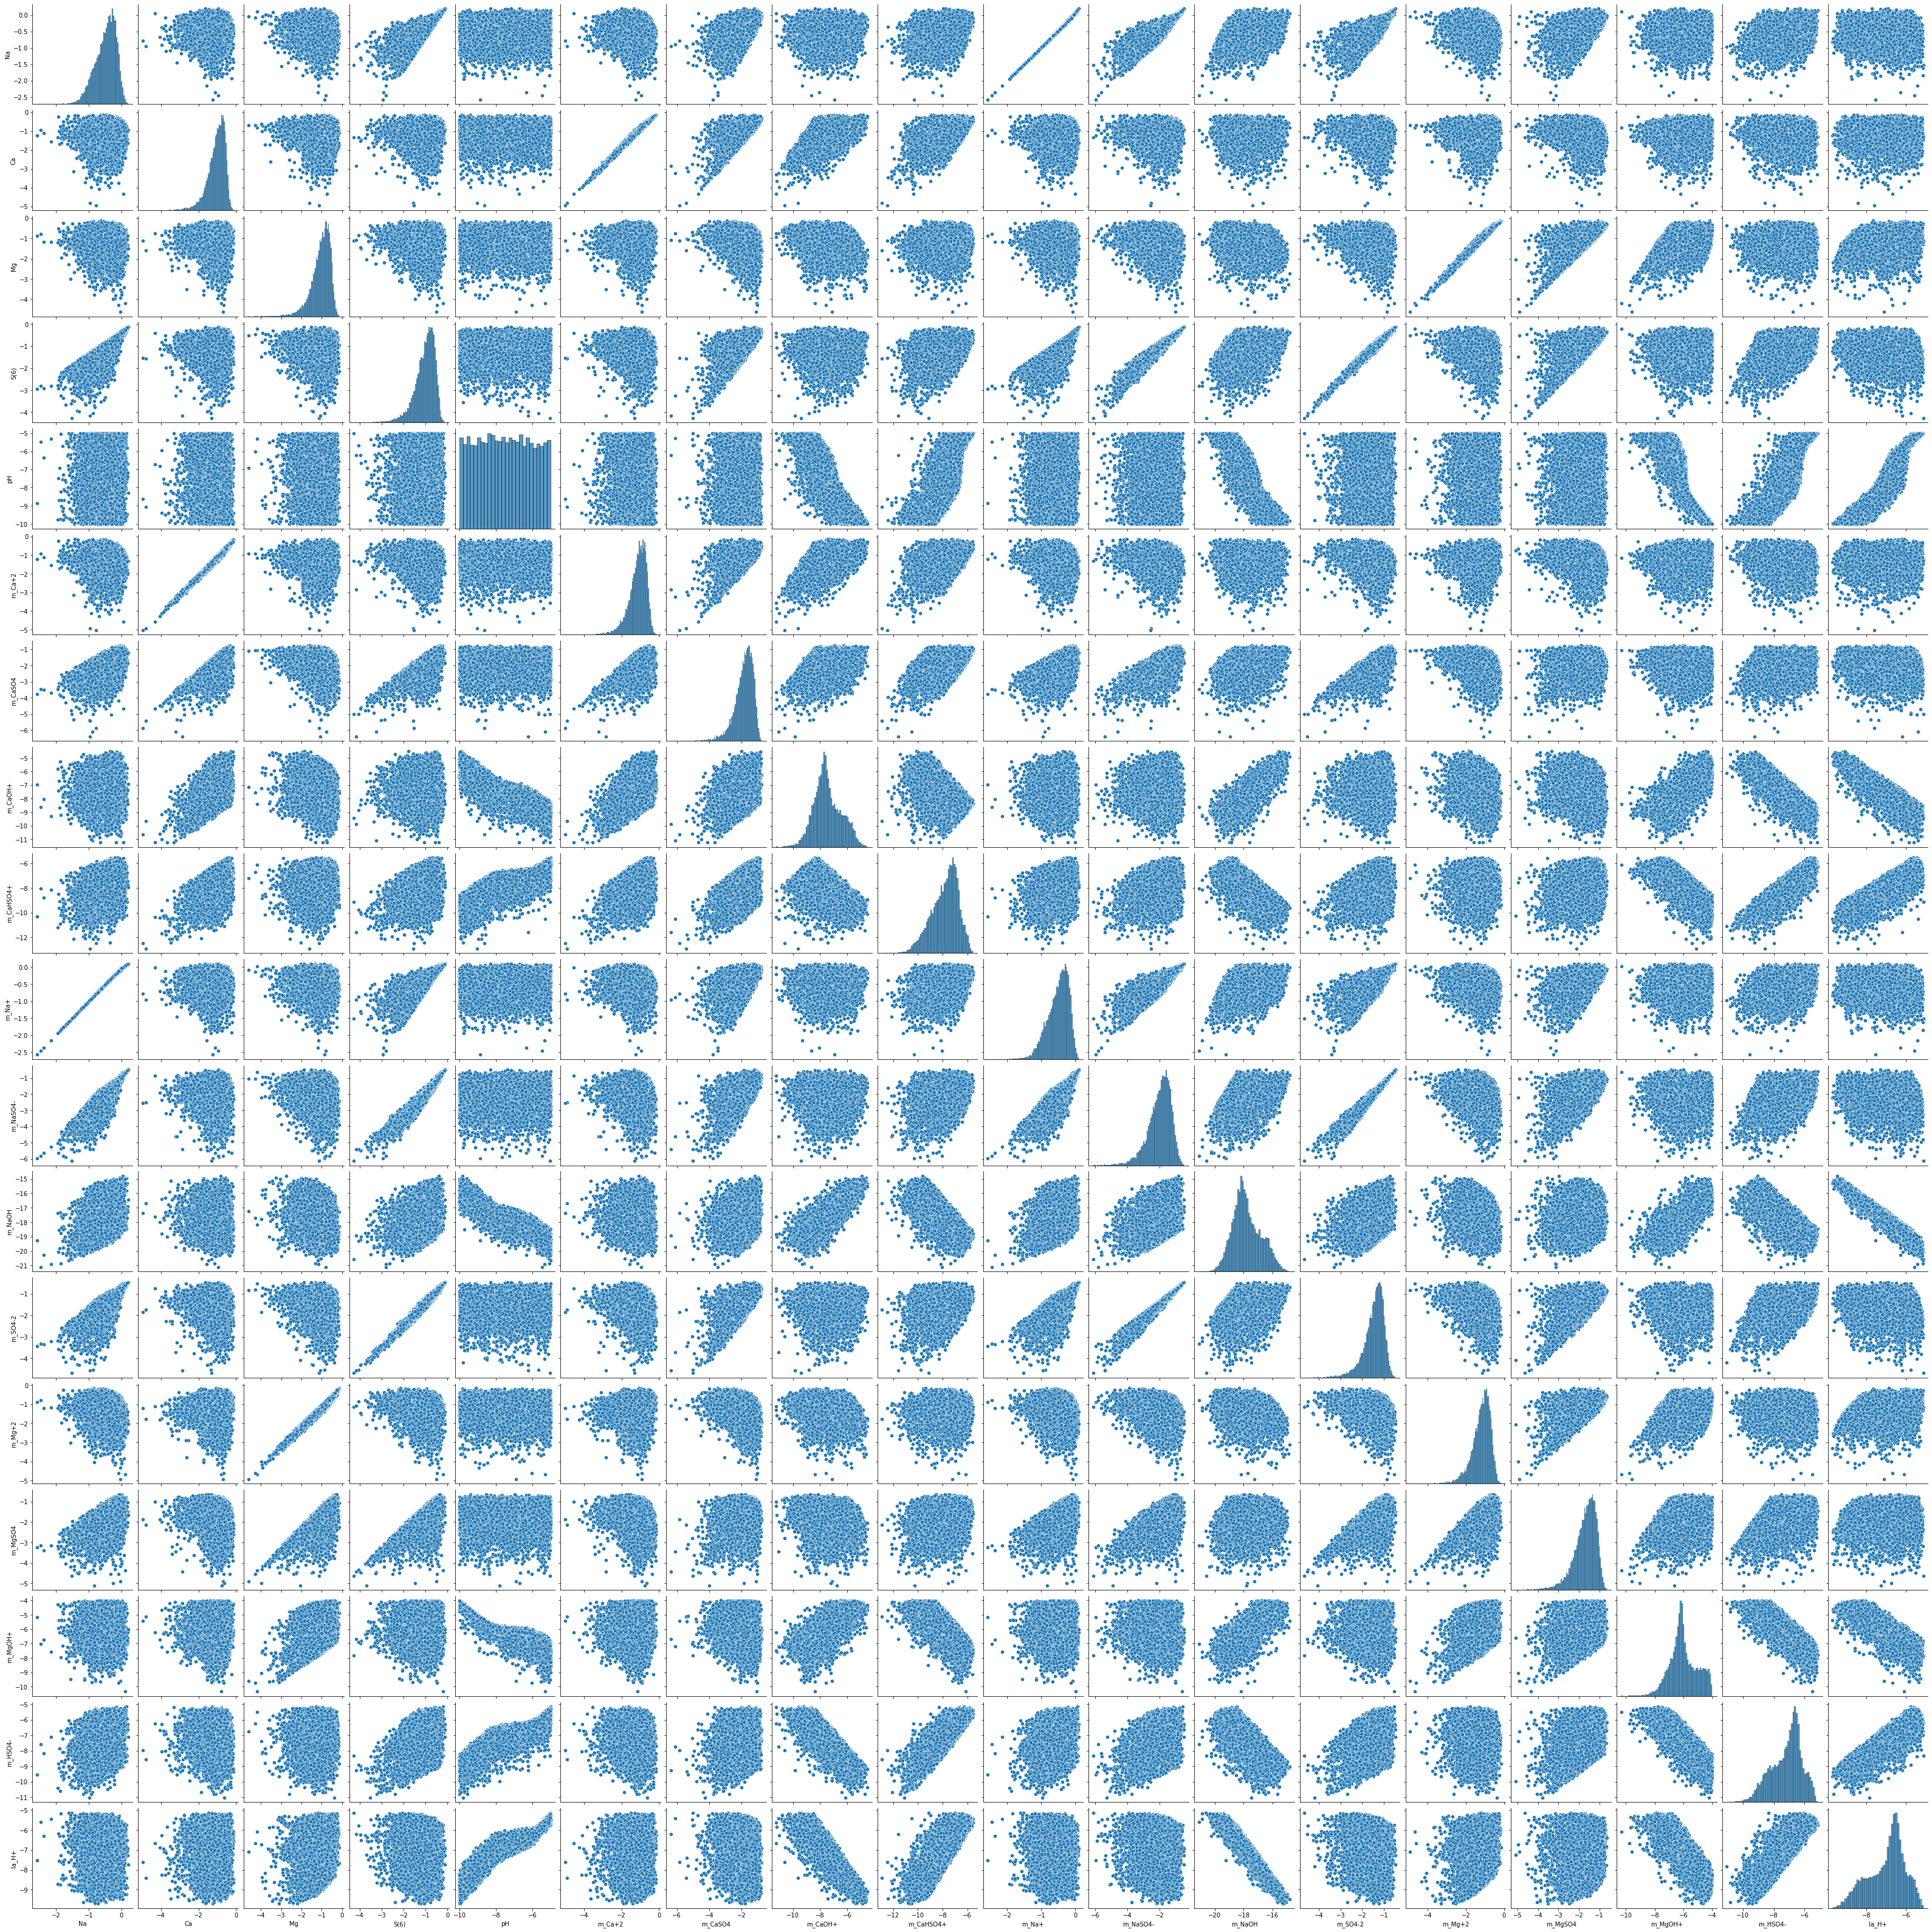

In [7]:
sns.pairplot(my_data)

***
## Base case - Neural Networks without Mass Constraint


#### Split database into training and testing

In [8]:
x = my_data.iloc[:, :5].to_numpy() # predictor features
y = my_data.iloc[:, 5:].to_numpy() # response features

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7173)

#### Define Neural Network Model
We define a Neural Network model that is constrained with respect to the mass balance of chemical components $Na$, $Ca$, $Mg$, and $S$. To tha end, we define the matrix $B$, that transform the first ouput layer into the component space, in order to compute the mass balance residuals for each data point.
$$
y\bullet B = mass_{output}
$$
This constraint is directly implemented in the output layer of the Neural Network. The matrix $B$ are calculated from the chemical formulas of the salts and ions in solution:

In [9]:
y_column_names = my_data.iloc[:,5:].columns # names of ions in solution

components = ['Na', 'Ca', 'Mg', 'S'] # name of components

B = [[parse_compound(column)[comp] if comp in column else 0.0 for column in y_column_names]
     for comp in components]
B = np.array(B).T

print(pd.DataFrame(data=B, columns = components, index= y_column_names))

            Na   Ca   Mg    S
m_Ca+2     0.0  1.0  0.0  0.0
m_CaSO4    0.0  1.0  0.0  1.0
m_CaOH+    0.0  1.0  0.0  0.0
m_CaHSO4+  0.0  1.0  0.0  1.0
m_Na+      1.0  0.0  0.0  0.0
m_NaSO4-   1.0  0.0  0.0  1.0
m_NaOH     1.0  0.0  0.0  0.0
m_SO4-2    0.0  0.0  0.0  1.0
m_Mg+2     0.0  0.0  1.0  0.0
m_MgSO4    0.0  0.0  1.0  1.0
m_MgOH+    0.0  0.0  1.0  0.0
m_HSO4-    0.0  0.0  0.0  1.0
la_H+      0.0  0.0  0.0  0.0


We next define the ANN model. Its arquitecture consists of an input layer with 5 neurons, two hidden layers with 8 and 16, respectively, and an output layer with 13 + 1 neurons, corresponding to the 12 species in solution, the pH and mass balance residual. The activation function tanh is used for the hidden layers as it is non-linear and continuosly differntiable. We also defined the new hyperparameter ```lambda_``` to penalize to different degree the neural networks for violating mass conservation.

The number of hidden layers, number of nodes, and activation functions were manually tuned to obtain a performance.

In [10]:
tf.keras.backend.set_floatx('float64')

In [11]:
def model(B, lambda_= 1.0, n_inputs = 5, n_outputs = 13):
    B_ = B
    
    # ANN arquitecture
    inputs = keras.Input(shape=(n_inputs,))
    x1 = keras.layers.Dense(8, activation='tanh')(inputs)
    x2 = keras.layers.Dense(16, activation='tanh')(x1)
    outputs_ions = keras.layers.Dense(n_outputs)(x2)
    
    # Convert B matrix and constants to tensor
    B_ = tf.convert_to_tensor(B_)
    B_ = tf.expand_dims(B_, axis = 0)
    lambda_ = tf.convert_to_tensor(lambda_, dtype='float64')
    
    # Constant to define the basis 10 for exponentials and logarithms
    a = tf.constant(10.0, dtype='float64')
    
    # Dot product of output layer with B matrix 
    mass_output = tf.keras.layers.Dot(axes=(1,1))([tf.math.pow(a, outputs_ions), B_])
    
    # Apply logarithm base 10 to calculated component mass
    mass_output = tf.math.divide(tf.math.log(mass_output), tf.math.log(a))
    
    # Define the input component mass
    mass_input = inputs[:,:-1]
    
    # Calculate deviation between inputs and outputs
    mass_balance = tf.math.subtract(mass_output, mass_input)
    mass_balance = tf.math.abs(mass_balance)
    
    # Add the residual of the all the mass balance calculations
    mass_balance =  tf.keras.backend.sum(mass_balance, axis=1)
    

    # Concatenate the first output layer with the constraint
    mass_balance = tf.expand_dims(mass_balance, axis=1)
    mass_balance = lambda_ * mass_balance
    
    outputs = tf.keras.layers.concatenate([outputs_ions, mass_balance], axis = 1)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

#### Instatiate and Compile Models

We instatiate the unconstrained model using a very small lambda and the constrained model with lambda equal to 1. Then, the models are compiled defining Adam algorithm as the optimizer and the loss function is defined in terms of the mean squared errors. 

In [23]:
# Instatiate models
uc_model = model(B, lambda_= 0.0) # Unconstrained model
c_model = model(B, lambda_= 10.0) # Constrained model

# Compile models
uc_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
c_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

---
### Training and Testing

We add an additional column with zeros to the training and testing response features for the mass balance constraint.

In [24]:
y_train_concat = np.concatenate([y_train, np.zeros((y_train.shape[0],1))], axis =1)
y_test_concat = np.concatenate([y_test, np.zeros((y_test.shape[0],1))], axis =1)

#### Constrained model

A callback is defined to obtain the best model parameters according to the loss values.

In [25]:
c_checkpoint_filepath = f'Trained_Models/constrained'
c_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=c_checkpoint_filepath,
                                                               save_weights_only=True,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)
# c_model.load_weights(c_checkpoint_filepath)

hist_const = c_model.fit(x_train, y_train_concat, validation_data = (x_test, y_test_concat ),
                       callbacks=[c_model_checkpoint_callback], batch_size=20, epochs=300, verbose= 0)

Here we plot the history of the loss values for the training and testing data.

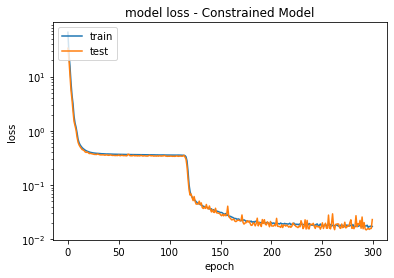

In [26]:
plt.plot(hist_const.history['loss'])
plt.plot(hist_const.history['val_loss'])
plt.title('model loss - Constrained Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

#### Unconstrained model

The same training procedure is repeated for the unconstrained model.

In [27]:
checkpoint_filepath = f'Trained_Models/unconstrained'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)
#c_model.load_weights(checkpoint_filepath)

hist_unconst = uc_model.fit(x_train, y_train_concat,
                        validation_data = (x_test, y_test_concat),
                        batch_size=20, epochs=300, verbose= 0)

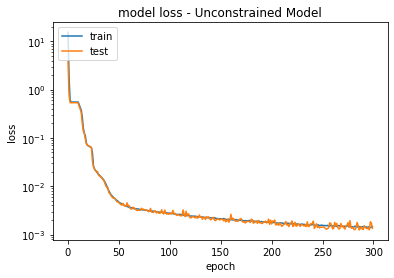

In [28]:
plt.plot(hist_unconst.history['loss'])
plt.plot(hist_unconst.history['val_loss'])
plt.title('model loss - Unconstrained Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')

---
## Results

Predict the results from the training and testing dataset

In [29]:
# Unconstrained model
uc_pred_train = uc_model.predict(x_train)
uc_pred_test = uc_model.predict(x_test)

# Constrained model
c_pred_train = c_model.predict(x_train)
c_pred_test = c_model.predict(x_test)

### Chemical Speciation

We first compare the goodness of the predictions for the concentration of ions and complexes in solutions.

#### Constrained Model

The results show a good agreement between the predicted and true values. There are some non-linearities in the predictions, particularly for the chemical species at low concentrations (very negative values).

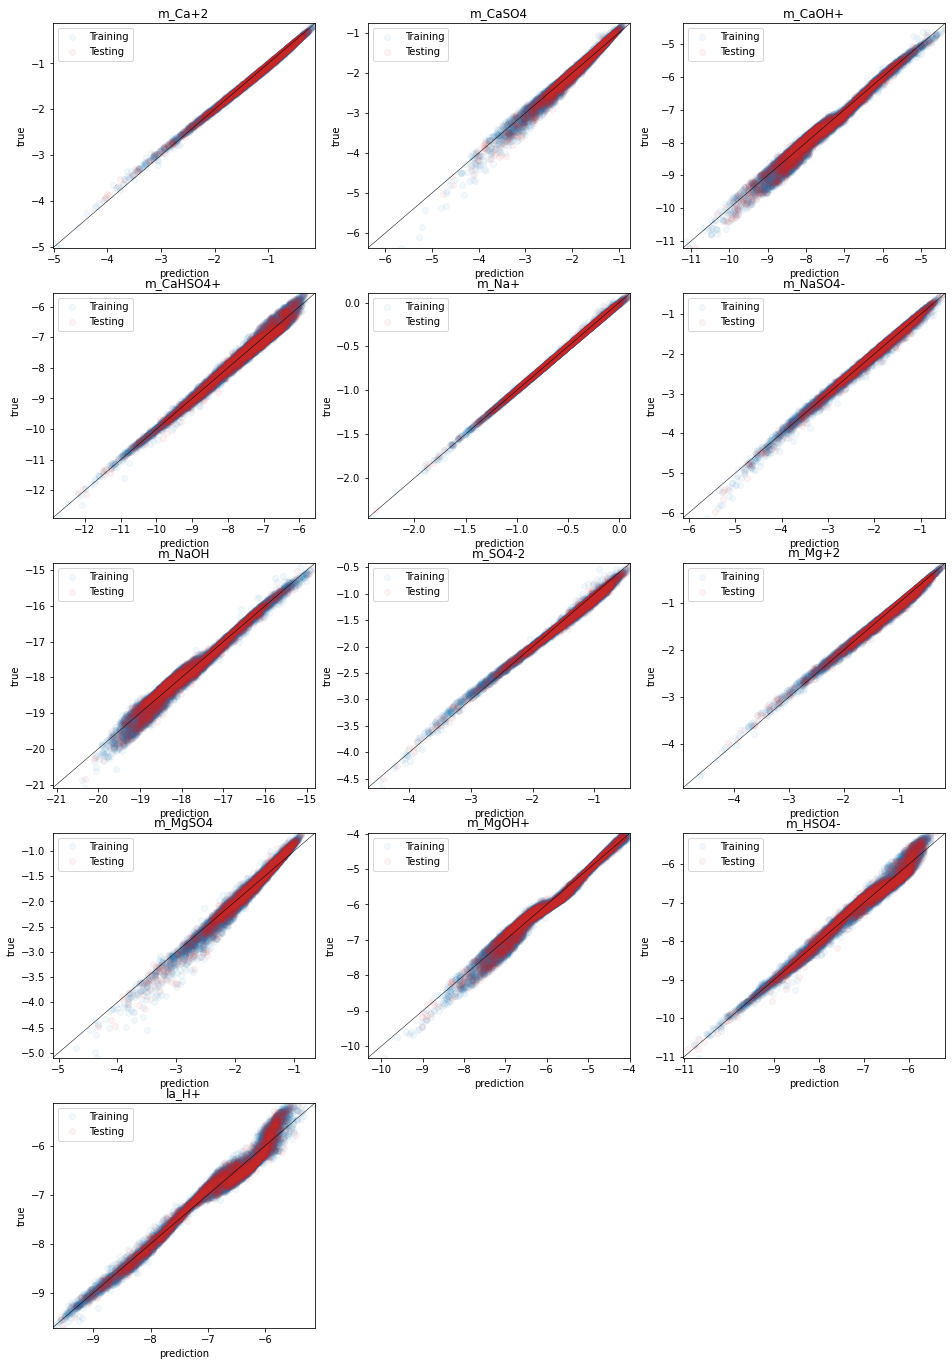

In [30]:
# Get limits
limits = {}
for i in range(13):
    limits[str(i)] = (np.min([y_train[:,i], c_pred_train[:,i]]), np.max([y_train[:,i], c_pred_train[:,i]]))

fig, axes = plt.subplots(5, 3, figsize=(16, 24), squeeze=False)
fig.delaxes(axes[4,2])
fig.delaxes(axes[4,1])

for i, ax in enumerate(axes.flatten()[:-2]):
    ax.plot(c_pred_train[:,i], y_train[:,i], 'o', label = 'Training', alpha=0.05, color='tab:blue')
    ax.plot(c_pred_test[:,i], y_test[:,i], 'o', label = 'Testing', alpha=0.05, color='tab:red')
    ax.plot(limits[str(i)], limits[str(i)], c='k', lw=0.5)
    ax.set_xlim(limits[str(i)]) ; ax.set_ylim(limits[str(i)])
    ax.legend()
    ax.set_title(y_column_names[i])
    ax.set_xlabel('prediction'); ax.set_ylabel('true')

#### Unconstrained Model

The predictions of the unconstrained model are in excellent agreement with the true values. Since mass balance is not considered, the model had a improved convergence compared to the constrained model.

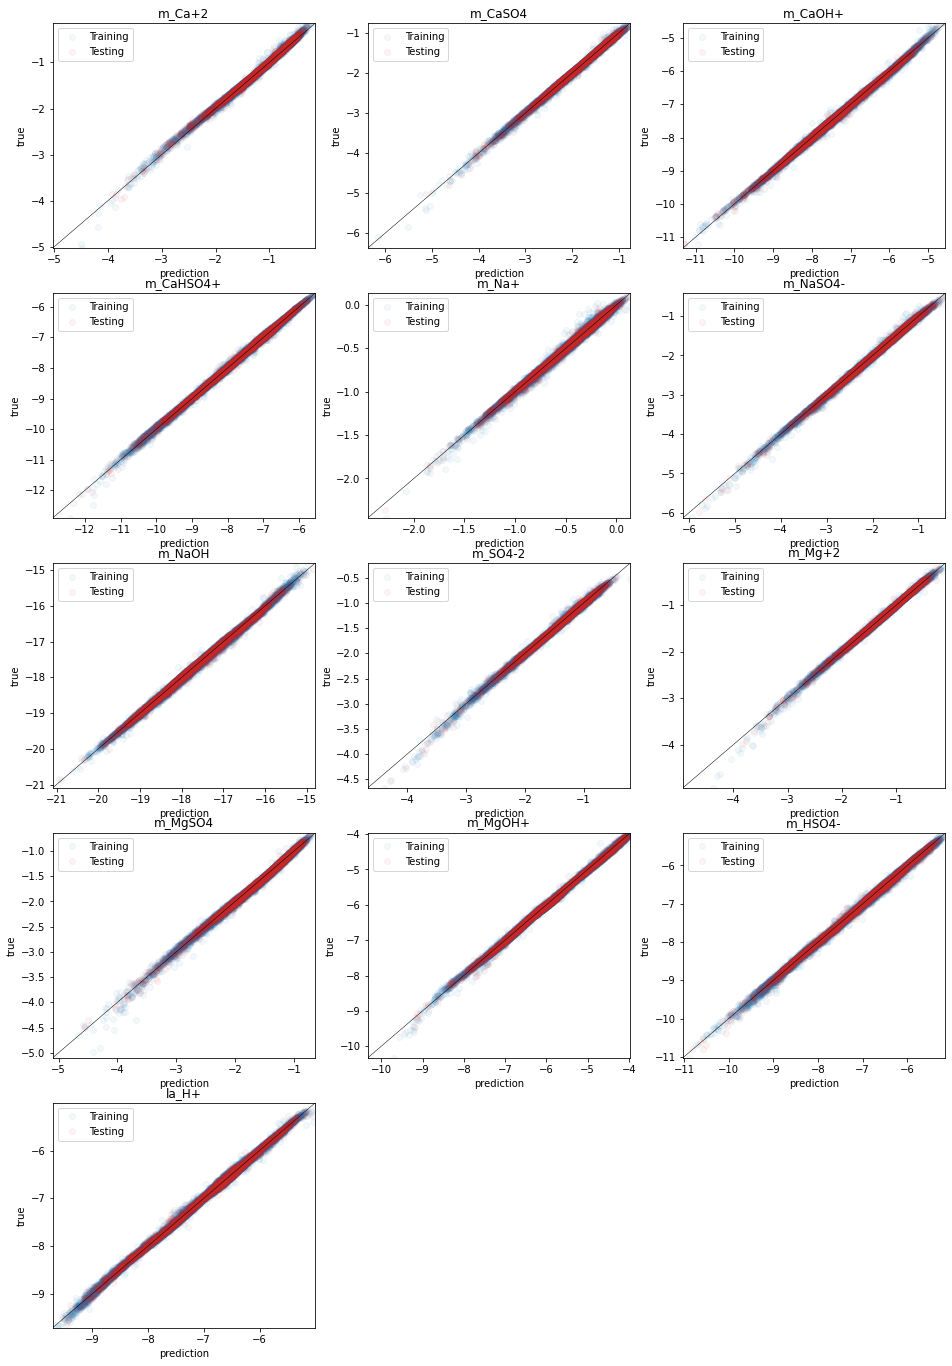

In [31]:
# Get limits
limits = {}
for i in range(13):
    limits[str(i)] = (np.min([y_train[:,i], uc_pred_train[:,i]]), np.max([y_train[:,i], uc_pred_train[:,i]]))


fig, axes = plt.subplots(5, 3, figsize=(16,24), squeeze=False)
fig.delaxes(axes[4,2])
fig.delaxes(axes[4,1])

for i, ax in enumerate(axes.flatten()[:-2]):
    ax.plot(uc_pred_train[:,i], y_train[:,i], 'o', label = 'Training', alpha=0.05, color='tab:blue')
    ax.plot(uc_pred_test[:,i], y_test[:,i], 'o', label = 'Testing', alpha=0.05, color='tab:red')
    ax.plot(limits[str(i)], limits[str(i)], c='k', lw=0.5)
    ax.set_xlim(limits[str(i)]) ; ax.set_ylim(limits[str(i)])
    ax.legend()
    ax.set_title(y_column_names[i])
    ax.set_xlabel('prediction'); ax.set_ylabel('true')

### Mass balance

Finally, we compare the predicted and true values of the total mass in the system for the constrained and unconstrained model. The total mass calculated from the constrained model's ouputs are clearly closer to the true values.

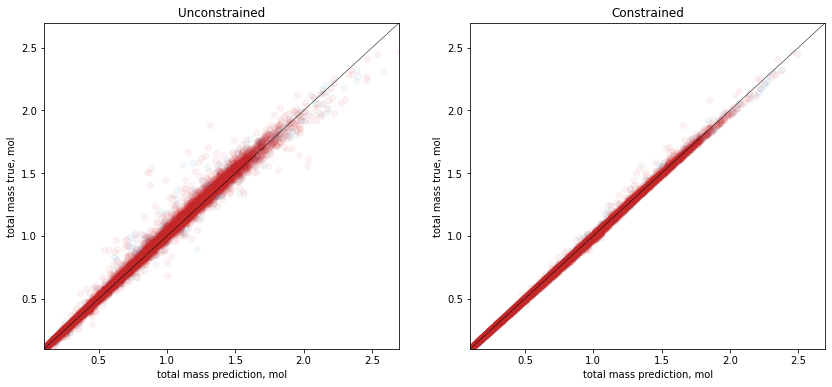

In [32]:
# Get the mass balance from the test and training data
c_mbal_test = np.sum(np.power(10,c_pred_test[:,:-1])@ B, axis=1)
uc_mbal_test = np.sum(np.power(10, uc_pred_test[:,:-1]) @ B, axis=1)
x_mbal_test = np.sum(np.power(10, x_test[:,:4]), axis=1)

c_mbal_train= np.sum(np.power(10,c_pred_train[:,:-1])@ B, axis=1)
uc_mbal_train = np.sum(np.power(10, uc_pred_train[:,:-1]) @ B, axis=1)
x_mbal_train = np.sum(np.power(10, x_train[:,:4]), axis=1)

# Calculate the limits of the plots
for i in range(13):
    min_value = np.min([uc_mbal_train, uc_mbal_train, x_mbal_train])
    max_value = np.max([uc_mbal_train, uc_mbal_train, x_mbal_train])
    limits = np.round(((min_value, max_value)),2)

    
# Plot figures    
fig, axes = plt.subplots(1, 2, figsize=(14,6),squeeze=False)

axes[0,0].plot(uc_mbal_test, x_mbal_test, 'o', label = 'Testing', alpha=0.05, color='tab:blue')
axes[0,0].plot(uc_mbal_train, x_mbal_train, 'o', label = 'Training', alpha=0.05, color='tab:red')
axes[0,0].set_title('Unconstrained')

axes[0,1].plot(c_mbal_test, x_mbal_test, 'o', label = 'Testing', alpha=0.05, color='tab:blue')
axes[0,1].plot(c_mbal_train, x_mbal_train, 'o', label = 'Training', alpha=0.05, color='tab:red')
axes[0,1].set_title('Constrained')

for ax in axes.flat:
    ax.plot(limits, limits, c='k', lw=0.5)
    ax.set_xlim(tuple(limits)); ax.set_ylim(tuple(limits))
    ax.set_xlabel('total mass prediction, mol'); ax.set_ylabel('total mass true, mol')

 ## Summary

Finally, in the plot below we compare the mass balance residuals distribution for each model. It is observed that the distribution for the lower values for the constrained model, while the distribution for the unconstrained model is more uniform. This indicates the improvement of the mass-constrained model.

average unconstrained =  0.0336282436378539
average constrained =  0.016209271452648315


std unconstrained =  0.03277749554743755
std constrained =  0.01099974375263899


Text(0.5, 1.0, 'Total Mass Balance Residuals')

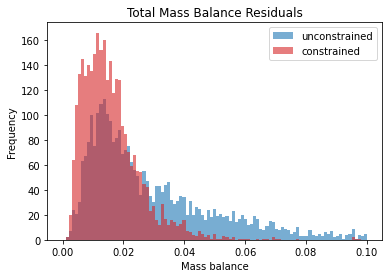

In [41]:
c_mbal_test = np.sum(np.abs(np.power(10,c_pred_test[:,:-1]) @ B - np.power(10, x_test[:,:4])), axis=1)
c_mbal_test_ave = np.average(c_mbal_test )
c_mbal_test_std = np.std(c_mbal_test )

uc_mbal_test = np.sum(np.abs(np.power(10, uc_pred_test[:,:-1]) @ B - np.power(10, x_test[:,:4])), axis=1)
uc_mbal_test_ave = np.average(uc_mbal_test )
uc_mbal_test_std = np.std(uc_mbal_test )


print('average unconstrained = ', uc_mbal_test_ave)
print('average constrained = ', c_mbal_test_ave)
print('\n')
print('std unconstrained = ', uc_mbal_test_std)
print('std constrained = ', c_mbal_test_std)

bins = np.linspace(0, 0.1, 100)

fig, ax = plt.subplots()

ax.hist(uc_mbal_test,label = 'unconstrained',bins = bins,  alpha = 0.6, color='tab:blue')
ax.hist(c_mbal_test,label = 'constrained', bins=bins, alpha = 0.6, color='tab:red')


ax.legend()
ax.set_xlabel('Mass balance'); ax.set_ylabel('Frequency')
ax.set_title('Total Mass Balance Residuals')

A constrained ANN model was build to improve the mass balance from chemical equilibrium calculations. The following summarize the results:

* Both the unconstrained and unconstrained models satisfactorily predicted the concentration of ions and complexes in solution as a function of the total concentrations of the chemical components.

* The comparison of the mass balance between the models indicates that the constrained ANN reduced the residual of the mass balance by almost one order of magnitude.

* The loss values for constrained model were significantly higher than the unconstrained model. Therefore, it is important to further investigate the impact of lambda and the optimization parameters to improve convergence.